In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import os 
import glob 
import medpy.io
%matplotlib inline

In [2]:
def create_data(in_path, out_path, verbose = True, min_max_norm = False, swapaxes = False, split_labels = True):
    total_patients = []
    #directory for training and testing 
    for d_00 in sorted(os.listdir(in_path)):
        #ignore zip files 
        if not d_00.endswith('.zip'):
            print(d_00)
            merge_d00 = os.path.join(in_path + d_00)
        #skip the loop for .zip extension 
        else:
            continue
        #create file directory [Training, Testing]
        save_path_01 = (out_path+d_00+'/')
        if not os.path.exists(save_path_01):
            os.makedirs(save_path_01)

        # training or testing > hgg or lgg
        for d_01 in sorted(os.listdir(merge_d00)):
            print(' ->',d_01)
            merge_d01 = os.path.join(merge_d00+'/'+d_01)
            patient_counts = 0
            #create file directory [HGG, LGG]
            save_path_02 = (save_path_01+d_01+'/')
            if not os.path.exists(save_path_02):
                os.makedirs(save_path_02)

            for steps_01, d_02 in enumerate(sorted(os.listdir(merge_d01))):
                break_01 = 0
                #debug
                #list only the first dir
                if steps_01==0:
                    break_01 = 1 
                    print('  -->', d_02) #patient name
                #
                patient_counts+=1
                merge_d02 = os.path.join(merge_d01+'/'+d_02)

                multimodal_name_list = []
                for steps_02, d_03 in enumerate(sorted(os.listdir(merge_d02))):
                    #create file 
                    multimodal_file_name = d_03.split('.')[-2] #MR_Flair, T2,..
                    multimodal_name_list.append(multimodal_file_name)
                    save_path_03 = (save_path_02+multimodal_file_name+'/')
                    if not os.path.exists(save_path_03):
                        os.makedirs(save_path_03)
                    #debug
                    #list only the first dir
                    if break_01==1 and steps_02 != 5:
                        print('   --->', d_03) #multimodal
                    #
                    merge_d03 = os.path.join(merge_d02+'/'+d_03)
                    #read files with wild card .mha ending
                    med_img = glob.glob('{}/*.mha'.format(merge_d03)) #return list!
                    save_path_04 = (save_path_02+multimodal_file_name+'/')
                    for mha in med_img:
                        read_med_img, _ = medpy.io.load(mha)
                        
                    #min max normalization switch, label 'OT' not included
                    if multimodal_file_name!= 'OT' and min_max_norm==True:
                        norm_list = []
                        for i in range(read_med_img.shape[-1]): #last channel is the slices 
                            max_val = np.max(read_med_img[:,:,i])
                            min_val = np.min(read_med_img[:,:,i])
                            norm = (read_med_img[:,:,i] - min_val)/(max_val-min_val)
                            norm_list.append(norm)

                        read_med_img = np.array(norm_list) #shape(155,240,240)
                        read_med_img = np.nan_to_num(read_med_img) #at times, max = 0, min = 0
                        if swapaxes==True: #=>(240, 240, 155)
                            read_med_img = np.swapaxes(read_med_img, 0,1)
                            read_med_img = np.swapaxes(read_med_img, 1,2)
                    #file name => e.g. MR_Flair_brats_2013_pat0103_1.npy (multimodal + patient name)
                    np.save(save_path_04+'{}_{}.npy'.format(multimodal_file_name, d_02), read_med_img)        
    #                 plt.imshow(read_med_img[:,:,20], cmap = 'gray')
    #                 plt.show()
            if verbose==True:
                print('*Number of patients: {}'.format(patient_counts))
                total_patients.append(patient_counts)
                print()
                
    if verbose==True:
        print()
        n_slices = 155
        t_patients = np.sum(total_patients)
        print('[Summary]')
        print('Total number of patients: {}'.format(t_patients))
        print('Total number of 2D images: {}'.format(t_patients*n_slices))
        print('  |_ Training: {}'.format((t_patients-total_patients[0])*n_slices))
        print('  |_ Testing: {}'.format(total_patients[0]*n_slices))

In [3]:
in_path = '/home/kevinteng/Desktop/BRATS2015/'
out_path = '/home/kevinteng/Desktop/BRATS_Pre/'
create_data(in_path, out_path, verbose = True, min_max_norm = True, swapaxes = True)

BRATS2015_Testing
 -> HGG_LGG
  --> brats_2013_pat0103_1
   ---> VSD.Brain.XX.O.MR_Flair.54193


/home/kevinteng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in true_divide


   ---> VSD.Brain.XX.O.MR_T1.54194
   ---> VSD.Brain.XX.O.MR_T1c.54195
   ---> VSD.Brain.XX.O.MR_T2.54196
*Number of patients: 110

BRATS2015_Training
 -> HGG
  --> brats_2013_pat0001_1
   ---> VSD.Brain.XX.O.MR_Flair.54512
   ---> VSD.Brain.XX.O.MR_T1.54513
   ---> VSD.Brain.XX.O.MR_T1c.54514
   ---> VSD.Brain.XX.O.MR_T2.54515
   ---> VSD.Brain_3more.XX.O.OT.54517
*Number of patients: 220

 -> LGG
  --> brats_2013_pat0001_1
   ---> VSD.Brain.XX.O.MR_Flair.54632
   ---> VSD.Brain.XX.O.MR_T1.54633
   ---> VSD.Brain.XX.O.MR_T1c.54634
   ---> VSD.Brain.XX.O.MR_T2.54635
   ---> VSD.Brain_3more.XX.O.OT.54637
*Number of patients: 54


[Summary]
Total number of patients: 384
Total number of 2D images: 59520
  |_ Training: 42470
  |_ Testing: 17050


----

# Sanity Check

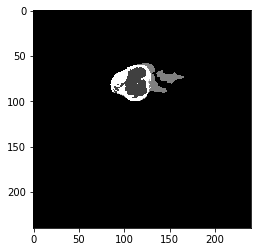

In [22]:
tmp_path = '/home/kevinteng/Desktop/OT_brats_2013_pat0001_1.npy'

img = np.load(tmp_path)
plt.imshow(img[:,:,50], cmap = 'gray')

In [23]:
print(np.min(img))
print(np.max(img))

0
4


In [24]:
core = np.where((img==1) | (img==3), img, 0)
enhancing_tumor = np.where(img==4, img, 0)
complete_tumor = np.where(img<=1, img, 1 )

In [25]:
label_plot = np.array([core[:,:,50], enhancing_tumor[:,:,50], complete_tumor[:,:,50]])

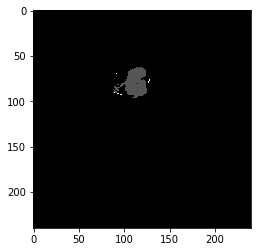

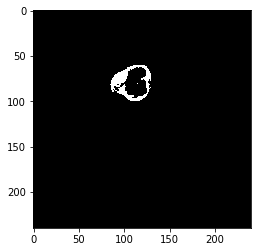

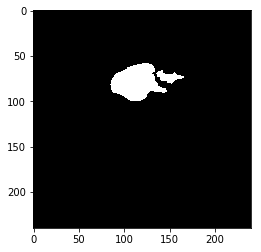

In [26]:
for img in label_plot:
    plt.imshow(img, cmap = 'gray')
    plt.show()

----

# Split Labels

Labels: 
- 0 => Non Tumor Tissue
- 1 => Necrosis
- 2 => Edema
- 3 => Non-enhancing Tumor 
- 4 => Enhancing Tumor

Tumor Segmentation:
- Label 1+3 => Core
- Label 4 => Enhancing Tumor
- Label 1+2+3+4 => Complete Tumor

In [9]:
training_hgg_label = '/home/kevinteng/Desktop/BRATS_Pre/BRATS2015_Training/HGG/OT/'
training_lgg_label = '/home/kevinteng/Desktop/BRATS_Pre/BRATS2015_Training/LGG/OT/'
desktop_hgg_path = '/home/kevinteng/Desktop/BRAT_lbl/HGG/'
desktop_lgg_path = '/home/kevinteng/Desktop/BRAT_lbl/LGG/'

In [12]:
def split_labels(inp_path, out_path):
    for lbls in sorted(os.listdir(inp_path)):
        patient_tag = lbls.split('.')[0]
        npy_path = os.path.join(inp_path+'/'+lbls)
        labels = np.load(npy_path)
        #labels path
        core_path = out_path+'core/'
        enhancing_tumor_path = out_path+'enhancing_tumor/'
        complete_tumor_path = out_path+'complete_tumor/'

        #core
        if not os.path.exists(core_path):
            os.makedirs(core_path)
        core = np.where((labels==1) | (labels==3), labels, 0)
        np.save(core_path+'core_{}.npy'.format(patient_tag), core)
        #enhancing tumor
        if not os.path.exists(enhancing_tumor_path):
            os.makedirs(enhancing_tumor_path)
        enhancing_tumor = np.where(labels==4, labels, 0)
        np.save(enhancing_tumor_path+'enhancing_tumor_{}.npy'.format(patient_tag), enhancing_tumor)

        #complete tumor
        if not os.path.exists(complete_tumor_path):
            os.makedirs(complete_tumor_path)
        complete_tumor = np.where(labels<=1, labels, 1 )
        np.save(complete_tumor_path+'complete_tumor_{}.npy'.format(patient_tag), complete_tumor)
    

In [13]:
split_labels(training_hgg_label, desktop_hgg_path)
split_labels(training_lgg_label, desktop_lgg_path)

----

# Sanity Check

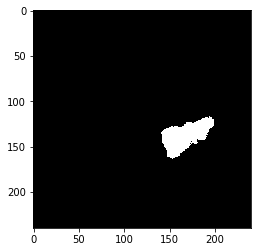

In [21]:
test_img = np.load('/home/kevinteng/Desktop/BRAT_lbl/HGG/complete_tumor/complete_tumor_OT_brats_2013_pat0002_1.npy')
plt.imshow(test_img[:,:,100], cmap='gray')